Harmful Content Detection using Traditional NLP Methods

This notebook implements a robust pipeline for detecting harmful/toxic content from social media platforms using traditional NLP methods. I will use TF-IDF vectorization and train multiple scikit-learn models to compare their performance on binary classification tasks.

Project Structure
1. Data Collection and Exploration
2. Text Preprocessing
3. Feature Engineering (TF-IDF)
4. Model Training (Multi-model)
5. Model Evaluation
6. Model Persistence
7. Comparative Analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
import warnings
warnings.filterwarnings('ignore')

# Libraries required for text processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Libraries required for modelling 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
import joblib

np.random.seed(42)

# Libraries requried for visualization 
plt.style.use('seaborn')
sns.set_palette("husl")


[nltk_data] Downloading package punkt to /Users/aashna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aashna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1. Data Collection and Exploration: Data will be exported from Kaggle - Jigsaw Comment Classification. 

In [17]:
# Loading the dataset -- stored in the root folder's sub-folder 
df = pd.read_csv('data/raw/train.csv')

# Basic info display of dataset 
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample of the data:")
display(df.head())

# Creation of toxic labels and assignment of binary classification e.g. 1 = positive, 0 = negative 
toxic_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['is_toxic'] = df[toxic_columns].max(axis=1)

# Display of the classification distribution
print("\nClass Distribution:")
print(df['is_toxic'].value_counts(normalize=True).round(3))

# # Visuals of text description 
# df['text_length'] = df['comment_text'].str.len()

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# sns.histplot(data=df, x='text_length', hue='is_toxic', bins=50)
# plt.title('Distribution of Text Lengths by Class')
# plt.xlabel('Text Length')

# plt.subplot(1, 2, 2)
# sns.boxplot(data=df, x='is_toxic', y='text_length')
# plt.title('Text Length by Class')
# plt.xlabel('Is Toxic')
# plt.ylabel('Text Length')

# plt.tight_layout()
# plt.show()


Dataset Shape: (159571, 8)

Columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Sample of the data:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0



Class Distribution:
0    0.898
1    0.102
Name: is_toxic, dtype: float64


In [6]:
# # 2. Text Preprocessing

# We'll create a preprocessing pipeline that includes:
# 1. Lowercasing
# 2. URL and HTML tag removal
# 3. Special character and punctuation removal
# 4. Stopword removal (optional)
# 5. Whitespace normalization


In [7]:
def preprocess_text(text):
    """
    Here the data will be pre-processed and cleaned
    """
    # Convert to string if not already
    text = str(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Strip URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Strip HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Strip special characters and punctuation whilst keeping important punctuation that might indicate sentiment
    text = re.sub(r'[^a-zA-Z\s!?.]', '', text)
    
    # Strip extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply preprocessing to the dataset
df['processed_text'] = df['comment_text'].apply(preprocess_text)

# Display examples for clarity and demonstrating difference in text appearance
print("Original vs Processed Text Examples:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print("Original:", df['comment_text'].iloc[i][:100], "...")
    print("Processed:", df['processed_text'].iloc[i][:100], "...")


Original vs Processed Text Examples:

Example 1:
Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't  ...
Processed: explanation why the edits made under my username hardcore metallica fan were reverted? they werent v ...

Example 2:
Original: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11 ...
Processed: daww! he matches this background colour im seemingly stuck with. thanks. talk january utc ...

Example 3:
Original: Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant  ...
Processed: hey man im really not trying to edit war. its just that this guy is constantly removing relevant inf ...


In [8]:
# # 3. Feature Engineering - TF-IDF Vectorization

# We'll use TF-IDF vectorization to convert our preprocessed text into numerical features. We'll configure it to:
# - Use unigrams and bigrams
# - Limit the maximum number of features
# - Apply sublinear TF scaling
# - Use L2 normalization


In [9]:
# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=10000,  # Limit vocabulary size
    ngram_range=(1, 2),  # Use unigrams and bigrams
    sublinear_tf=True,   # Apply sublinear scaling
    norm='l2',           # Use L2 normalization
    stop_words='english' # Remove English stopwords
)

# Split the data
X = df['processed_text']
y = df['is_toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Display some information about the features
print("Number of features:", len(tfidf.get_feature_names_out()))
print("\nSample features:")
print(tfidf.get_feature_names_out()[:10])

# Get the shape of the transformed data
print("\nTraining data shape:", X_train_tfidf.shape)
print("Testing data shape:", X_test_tfidf.shape)


Number of features: 10000

Sample features:
['aaron' 'ab' 'abandoned' 'abc' 'abide' 'abilities' 'ability' 'able'
 'able edit' 'abortion']

Training data shape: (127656, 10000)
Testing data shape: (31915, 10000)


4. Model Training - Multi-Model Classification

We'll train three different models:
1. Logistic Regression
2. Random Forest
3. Linear SVM

Each model will be evaluated using the same metrics for fair comparison.

In [11]:
# Initialize + training of models

#Initialize 
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Linear SVM': LinearSVC(random_state=42, max_iter=1000)
}

# Dictionary to store results
results = {}

# Training of models
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    if isinstance(model, LinearSVC):
        y_pred = model.predict(X_test_tfidf)
    else:
        y_pred = model.predict(X_test_tfidf)
    
    # Calculate metrics + evaluation 
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }
    
    print(f"{name} Results:")
    print(f"Accuracy: {results[name]['accuracy']:.3f}")
    print(f"F1 Score: {results[name]['f1']:.3f}")
    print("\nClassification Report:")
    print(results[name]['classification_report'])



Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.956
F1 Score: 0.744

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28670
           1       0.91      0.63      0.74      3245

    accuracy                           0.96     31915
   macro avg       0.94      0.81      0.86     31915
weighted avg       0.95      0.96      0.95     31915


Training Random Forest...
Random Forest Results:
Accuracy: 0.955
F1 Score: 0.751

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28670
           1       0.85      0.67      0.75      3245

    accuracy                           0.95     31915
   macro avg       0.91      0.83      0.86     31915
weighted avg       0.95      0.95      0.95     31915


Training Linear SVM...
Linear SVM Results:
Accuracy: 0.958
F1 Score: 0.769

Classification Report:
              precisio

5. Model Evaluation

Visualizing model performance using:
1. Confusion matrices
2. Comparative bar plots of accuracy and F1 scores


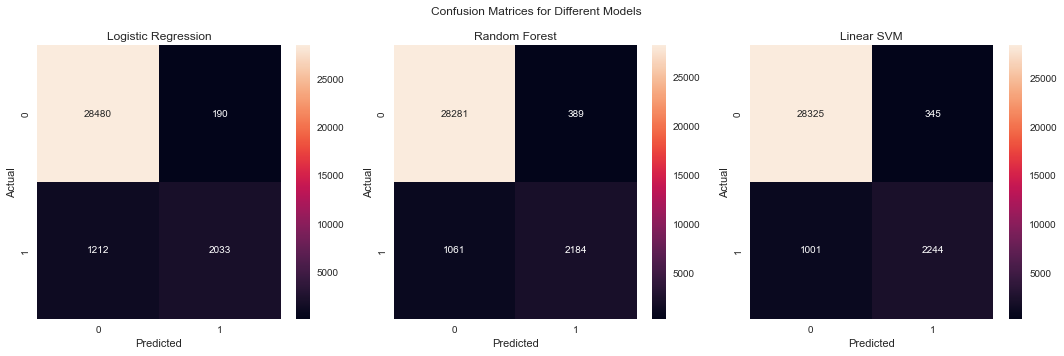

<Figure size 720x432 with 0 Axes>

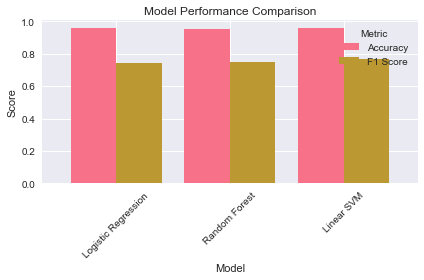


Model Performance Summary:


,Accuracy,F1 Score
Logistic Regression,0.956,0.744
Random Forest,0.955,0.751
Linear SVM,0.958,0.769


In [13]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Confusion Matrices for Different Models')

for i, (name, result) in enumerate(results.items()):
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Create comparative bar plot
metrics = ['accuracy', 'f1']
model_names = list(results.keys())
metric_values = {
    'Accuracy': [results[model]['accuracy'] for model in model_names],
    'F1 Score': [results[model]['f1'] for model in model_names]
}

df_metrics = pd.DataFrame(metric_values, index=model_names)

plt.figure(figsize=(10, 6))
df_metrics.plot(kind='bar', width=0.8)
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the results in a table
print("\nModel Performance Summary:")
display(df_metrics.round(3))


6. Model Persistence

Best performing model will be saved and the TF-IDF vectorizer for future use. A function will be created to demonstrate how to save and use the model for inference.

In [15]:
# Determining best performing model based on F1 score
best_model_name = max(results.items(), key=lambda x: x[1]['f1'])[0]
best_model = models[best_model_name]

# Saving the best model + vectorizer
joblib.dump(best_model, 'best_model.joblib')
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

print(f"Best performing model ({best_model_name}) and TF-IDF vectorizer have been saved.")

# Function for predictions -- to predict if a text is toxic using the model 
def predict_toxicity(text, model=best_model, vectorizer=tfidf):
    # Preprocess the text
    processed = preprocess_text(text)
    
    # Text transformation using fitted vectorizer
    text_tfidf = vectorizer.transform([processed])
    
    # Predictions
    prediction = model.predict(text_tfidf)[0]
    
    return {
        'text': text,
        'is_toxic': bool(prediction),
        'processed_text': processed
    }

# Testing function using examples
test_texts = [
    "You are a wonderful person!",
    "I hate you and everything you stand for!",
    "The weather is nice today."
]

print("\nTesting the prediction function:")
for text in test_texts:
    result = predict_toxicity(text)
    print(f"\nText: {result['text']}")
    print(f"Processed: {result['processed_text']}")
    print(f"Is it Toxic?: {result['is_toxic']}")


Best performing model (Linear SVM) and TF-IDF vectorizer have been saved.

Testing the prediction function:

Text: You are a wonderful person!
Processed: you are a wonderful person!
Is Toxic: False

Text: I hate you and everything you stand for!
Processed: i hate you and everything you stand for!
Is Toxic: True

Text: The weather is nice today.
Processed: the weather is nice today.
Is Toxic: False


7. Conclusion and Next Steps

Toxic content detection has been successfully created using traditional NLP methods. Here's what was accomplished:

1. Built a complete pipeline from data preprocessing to model deployment
2. Compared multiple classical ML models
3. Created a reusable prediction function
4. Saved our best model for future use

Potential improvements:
1. Adding more features like sentiment scores
2. Implementing cross-validation for more robust evaluation
3. Creating a simple web interface using Flask/Streamlit

To use this model in production:
1. Load the saved model and vectorizer:
```
model = joblib.load('best_model.joblib')
vectorizer = joblib.load('tfidf_vectorizer.joblib')
```

2. Use the predict_toxicity function:
```
result = predict_toxicity("your text here", model, vectorizer)
```